# Chicago: "we makin' cars"
Implement the Formula SAE contectualized design problem from Zurita et al

## TO DO: CHECK UNITS
everywhere, esp when importing tables

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import chi
# from opteval import benchmark_func as bf
import matplotlib

#for server:
# matplotlib.use('Agg')

#for retina:
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import copy
import time as timer
import threading
import pickle

# from sklearn import linear_model

## Helper Functions

In [2]:
def cp(x): #make a copy instead of reference
    return copy.deepcopy(x)

def isNumber(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def isNaN(num):
    return num != num

def mean(x):
    return np.mean(x)

def norm(x):
    return float(np.linalg.norm(x))

def dist(x,y):
    return np.linalg.norm(np.array(x)-np.array(y))

def bounds(x,low,high):
    if x > high:
        return high
    if x < low:
        return low
    return x

In [3]:
def makeAiScore():
    ai = np.random.normal(97,17)
    ai = bounds(ai, 40,150)
    return ai

def makeIqScore(): #this IQ ranges from 0 to 1, bc it is basically efficiency
    iq = np.random.normal(0.5,0.2)
    iq = bounds(iq, 0.1,1.0)
    return iq

def pickWorseScore(betterScore,worseScore,temperature):
    if temperature <=1E-6: #never pick worse answers, and avoid devide by 0
        return False
    if np.random.uniform(0,1) < np.exp((betterScore-worseScore)/temperature):  #
        return True 
    return False

def calculateDecay(steps,T0=1.0,Tf=0.01):
    if T0<=Tf or T0<=0: 
        return 0
    return (Tf / float(T0) ) ** (1/steps)
  
def calculateAgentDecay(agent, steps):
    E_N = normalizedE(agent.kai.E)
    E_transformed = np.exp((E_N*-1)+3.3)
    startEndRatio = bounds(1/E_transformed, 1E-10,1)
    T0 = agent.temp
    TF = T0 * startEndRatio
    return calculateDecay(steps,T0,TF)

## constants and params

In [4]:
complexSharing = True #if False, shareBasic() is used, eg strictly-greedy one-dimension jump 
commBonus = 10 #increasing the communication bonus makes successful communication more likely
commRange = 180
selfBias = 0 #increasing self bias will make agents choose their solutions more over others
startRange = 10
nDims = 2

SO_STRENGTH = 10
RG_STRENGTH = 10
TEAM_MEETING_COST = 1 #1 turn

VERBOSE = False

AVG_SPEED = 1
SD_SPEED = .5
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.5

## Load Table of parameters

In [5]:
#FIRST TIME:
paramsDF = pd.read_csv("./SAE/paramDB.csv")
paramsDF.columns = ['paramID','name','variable','team','kind','minV','maxV','used']
# paramsDF.at[3,"maxV"] = np.pi/4
# paramsDF.at[10,"maxV"] = np.pi/4
paramsDF.at[17,"maxV"] = np.pi /4
paramsDF.used = pd.to_numeric(paramsDF.used)
paramsDF = paramsDF.drop(columns=["paramID"],axis=1)
#remove unused variables... print(len(paramsDF))
paramsDF = paramsDF.loc[paramsDF.used > 0 ]
paramsDF.to_csv("./SAE/paramDBreduced.csv")
paramsDF = pd.read_csv("./SAE/paramDBreduced.csv")
print(len(paramsDF))
paramsDF = paramsDF.drop(["used"],axis=1)
paramsDF.head()

56


,Unnamed: 0,name,variable,team,kind,minV,maxV
0,0,rear wing height,hrw,rw,1,0.025,0.7
1,1,rear wing length,lrw,rw,1,0.05,0.25
2,2,rear wing width,wrw,rw,1,300,r_track-2*rear_wheel_r
3,3,rear wing angle of attack,arw,rw,1,0,0.7853981634
4,5,rear wing y position,yrw,rw,1,.500 + (h_rw)/2,1.200 - (h_rw)/2


In [6]:
paramsDF.loc[paramsDF.variable == "asw"]

,Unnamed: 0,name,variable,team,kind,minV,maxV
15,17,side wings angle of attack,asw,sw,1,0,0.7853981633974483


In [7]:
#logical vector for parameters with fixed min/max (TRUE), or min/max as f(p) (FALSE)
hasNumericBounds = [True if isNumber(row.minV) and isNumber(row.maxV) else False for i, row in paramsDF.iterrows()]

In [8]:
# materialsDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/materials.csv")
# materialsDF.q = [int(1 + np.random.uniform(0.98,1.02)*materialsDF.iloc[i]['q']) for i in range(len(materialsDF))]
# materialsDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/materialsTweaked.csv")
materialsDF = pd.read_csv("./SAE/materialsTweaked.csv")
materialsDF.head()

,Unnamed: 0,Material,Code,q,E
0,0,Glass-filled epoxy (35%),GFE,1890,1900000000
1,1,Glass-filled polyester (35%),GFP,1989,2000000000
2,2,Glass-filled nylon (35%),GFN,1607,1600000000
3,3,S-glass epoxy (45%),SGE,1781,1800000000
4,4,Carbon epoxy (61%),CE,1627,1600000000


In [9]:
tiresDF = pd.read_csv("./SAE/tires.csv")
tiresDF

,ID,radius,mass
0,T1,0.22860,3.636
1,T2,0.22987,4.091
2,T3,0.23241,4.545
3,T4,0.24638,4.545
4,T5,0.24765,5.000
5,T6,0.26670,5.000
6,T7,0.26670,5.000
7,T8,0.26162,5.455


In [10]:
# motorsDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/motors.csv")
# # first time: we want to make motors with the same power slightly different:
# motorsDF.Power = [int(1 + np.random.uniform(0.98,1.02)*motorsDF.iloc[i]['Power']) for i in range(len(motorsDF))]
# motorsDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/motorsTweaked.csv")
enginesDF = pd.read_csv("./SAE/motorsTweaked.csv")
print("unique" if len(enginesDF)-len(np.unique(enginesDF.Power)) == 0 else "not uniuqe")
enginesDF.columns = ["ind","id","name","le","we","he","me","Phi_e","T_e"]
enginesDF.head()

unique


,ind,id,name,le,we,he,me,Phi_e,T_e
0,0,M1,GX200,0.321,0.376,0.346,16.1,4157,912.4
1,1,M2,GX240,0.380,0.429,0.422,27.5,5980,18.3
2,2,M3,GX270,0.380,0.429,0.422,25.0,6208,19.1
3,3,M4,GX340,0.407,0.485,0.449,31.5,7866,26.4
4,4,M5,GXV340,0.433,0.382,0.406,32.3,6677,21.6


In [11]:
# susDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/suspension.csv")
# susDF.krsp = [int(np.random.uniform(0.98,1.02)*susDF.iloc[i]['krsp']) for i in range(len(susDF))]
# susDF.kfsp = susDF.krsp
# susDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/suspensionTweaked.csv")
susDF = pd.read_csv("./SAE/suspensionTweaked.csv")
print("unique" if len(susDF)-len(np.unique(susDF.krsp)) == 0 else "not uniuqe")
susDF = susDF.drop(columns=[susDF.columns[0]])
susDF.head()

unique


,id,krsp,crsp,mrsp,kfsp,cfsp,mfsp
0,S1,3982,600,0.3,3982,600,0.3
1,S2,21189,2000,0.3,21189,2000,0.3
2,S3,20784,2000,0.3,20784,2000,0.3
3,S4,21231,2000,0.3,21231,2000,0.3
4,S5,20650,2000,0.3,20650,2000,0.3


In [12]:
# brakesDF = pd.read_csv("/Users/samlapp/Documents/THRED Lab/SAE/brakes.csv")
# brakesDF.columns = [a.strip() for a in brakesDF.columns]
# brakesDF.rbrk = [np.random.uniform(0.98,1.02)*brakesDF.iloc[i]['rbrk'] for i in range(len(brakesDF))]
# brakesDF.to_csv("/Users/samlapp/Documents/THRED Lab/SAE/brakesTweaked.csv")
brakesDF = pd.read_csv("./SAE/brakesTweaked.csv")
print("unique" if len(brakesDF)-len(np.unique(brakesDF['rbrk'])) == 0 else "not uniuqe")
brakesDF = brakesDF.drop(columns=[brakesDF.columns[0]])
brakesDF.head()

unique


,brakeID,qbrk,lbrk,hbrk,wbrk,tbrk,rbrk
0,B1,0.4,0.10,0.0425,0.0200,0.350,0.025447
1,B2,0.4,0.14,0.0490,0.0175,0.350,0.024598
2,B3,0.4,0.14,0.0615,0.0175,0.350,0.027990
3,B4,0.5,0.10,0.0380,0.0160,0.350,0.030169
4,B5,0.5,0.10,0.0425,0.0200,0.355,0.031523


In [13]:
paramsDF.variable

0       hrw
1       lrw
2       wrw
3       arw
4       yrw
5       qrw
6       hfw
7       lfw
8       wfw
9       afw
10      yfw
11      qfw
12      hsw
13      lsw
14      wsw
15      asw
16      ysw
17      qsw
18      Prt
19      rrt
20      mrt
21      Pft
22      rft
23      mft
24       ye
25    Phi_e
26       le
27       he
28      T_e
29       me
30       hc
31       lc
32       wc
33       tc
34       yc
35       qc
36      hia
37      lia
38      wia
39      yia
40      qia
41      Eia
42     qbrk
43     lbrk
44     hbrk
45     wbrk
46     tbrk
47     rbrk
48     yrsp
49     krsp
50     crsp
51     mrsp
52     yfsp
53     kfsp
54     cfsp
55     mfsp
Name: variable, dtype: object

In [14]:
class Params:
    def __init__(self,v = paramsDF):
        self.vars = v.variable
        self.team = v.team
        for i, row in v.iterrows():
            setattr(self, row.variable.strip(),-1)
p = Params()
for v in p.vars:
    value = np.random.uniform()
    setattr(p,v,value)
paramsDF.loc[paramsDF.variable=="hrw"]["team"][0]

teams = np.unique(paramsDF.team)
teamDimensions = [[row.team == t for i, row in paramsDF.iterrows()] for t in teams]
teamDictionary = {}
for i in range(len(teams)):
    teamDictionary[teams[i]] = teamDimensions[i]
paramList = np.array(paramsDF.variable)

In [15]:
#convert parameter vector to Parameter object
pNames = paramsDF.variable
blankParameterObject = Params()
def asParameters(pList):
    p = cp(blankParameterObject)
    for i in range(len(pList)):
        setattr(p,pNames[i],pList[i])
    return p

numberParameters = len(paramsDF)
def asVector(params):
    r = np.zeros(numberParameters)
    for i in range(numberParameters):
        pName = pNames[i]
        r[i] = getattr(params,pName)
    return r

In [16]:
p = startParams()
v = asVector(p)

NameError: name 'startParams' is not defined

In [17]:
%timeit asParameters(v)
%timeit asVector(p)

201 µs ± 7.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
448 µs ± 3.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Objective Subfunctions

### constants

The car’s top velocity vcar is 26.8 m/s (60 mph).

The car’s engine speed x_e is 3600 rpm. 

The density of air q_air during the race is 1.225 kg/m3. 

The track radio of curvature r_track is 9 m. 

The pressure applied to the brakes Pbrk is 1x10^7 Pa


In [18]:
#scale parameters to go between unit cube (approximately) and SI units
paramMaxValues = []

In [19]:
v_car = 26.8 #m/s (60 mph)
w_e = 3600 * 60 * 2 *np.pi #rpm  to radians/sec 
rho_air = 1.225 #kg/m3.
r_track = 9 #m
P_brk = 10**7 #Pascals
C_dc = 0.04 #drag coefficient of cabin
gravity = 9.81 #m/s^2

In [20]:
#mass (minimize)
def mrw(p):
    return p.lrw * p.wrw *p.hrw * p.qrw
def mfw(p):
    return p.lfw * p.wfw *p.hfw * p.qfw
def msw(p):
    return p.lsw * p.wsw *p.hsw * p.qsw
def mia(p):
    return p.lia * p.wia *p.hia * p.qia
def mc(p):
    return 2*(p.hc*p.lc*p.tc + p.hc*p.wc*p.tc + p.lc*p.hc*p.tc)*p.qc
def mbrk(p):
    #CHRIS missing parameters: how is mbrk calculated? assuming lrw*rho
    return p.lbrk * p.wbrk * p.hbrk * p.qbrk
def mass(p): #total mass, minimize
    mass = mrw(p) + mfw(p) + 2 * msw(p) + 2*p.mrt + 2*p.mft + p.me + mc(p) + mia(p) + 4*mbrk(p) + 2*p.mrsp + 2*p.mfsp
    return mass

In [21]:
#center of gravity height, minimize
def cGy(p): 
    t1 =  (mrw(p)*p.yrw + mfw(p)*p.yfw+ p.me*p.ye + mc(p)*p.yc + mia(p)*p.yia) / mass(p)
    t2 = 2* (msw(p)*p.ysw + p.mrt*p.rrt + p.mft*p.rft + mbrk(p)*p.rft + p.mrsp*p.yrsp + p.mfsp*p.yfsp) / mass(p)
    
    return t1 + t2  

In [22]:
#Drag (minimize) and downforce (maximize)
def AR(w,alpha,l): #aspect ratio of a wing
    return w* np.cos(alpha) / l
    
def C_lift(AR,alpha): #lift coefficient of a wing
    return 2*np.pi* (AR / (AR + 2)) * alpha

def C_drag(C_lift, AR): #drag coefficient of wing
    return C_lift**2 / (np.pi * AR)

def F_down_wing(w,h,l,alpha,rho_air,v_car): #total downward force of wing
    wingAR = AR(w,alpha,l)
    C_l = C_lift(wingAR, alpha)
    return 0.5 * alpha * h * w * rho_air * (v_car**2) * C_l

def F_drag_wing(w,h,l,alpha,rho_air,v_car): #total drag force on a wing
    wingAR = AR(w,alpha,l)
#     print(wingAR)
    C_l = C_lift(wingAR, alpha)
#     print(C_l)
    C_d = C_drag(C_l,wingAR)
#     print(C_d)
    return F_drag(w,h,rho_air,v_car,C_d)
    
def F_drag(w,h,rho_air,v_car,C_d):
    return 0.5*w*h*rho_air*v_car**2*C_d

def F_drag_total(p): #total drag on vehicle
    cabinDrag = F_drag(p.wc,p.hc,rho_air,v_car,C_dc)
    rearWingDrag = F_drag_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    frontWingDrag = F_drag_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    sideWingDrag = F_drag_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    return rearWingDrag + frontWingDrag + 2* sideWingDrag + cabinDrag

def F_down_total(p): #total downforce
    downForceRearWing = F_down_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    downForceFrontWing = F_down_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    downForceSideWing = F_down_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    return downForceRearWing + downForceFrontWing + 2*downForceSideWing

In [23]:
#acceleration (maximize)
def rollingResistance(p,tirePressure,v_car):
    C = .005 + 1/tirePressure * (.01 + .0095 * (v_car**2))
    return C * mass(p) * gravity

def acceleration(p):
    mTotal = mass(p)
    tirePressure = p.Prt #CHRIS should it be front or rear tire pressure?
    total_resistance = F_drag_total(p) + rollingResistance(p, tirePressure,v_car)
    
    w_wheels = v_car / p.rrt #rotational speed of rear tires
    
    efficiency = total_resistance * v_car / p.Phi_e
    
    torque = p.T_e
    
    #converted units of w_e from rpm to rad/s !!!
    F_wheels = torque * efficiency * w_e /(p.rrt * w_wheels) 
    
    return (F_wheels - total_resistance) / mTotal
# acceleration(p)

In [24]:
#crash force (minimize)
def crashForce(p):
    return np.sqrt(mass(p) * v_car**2 * p.wia * p.hia * p.Eia / (2*p.lia))

In [25]:
#impact attenuator volume (minimize)
def iaVolume(p):
    return p.lia*p.wia*p.hia

In [26]:
#corner velocity (maximize)
y_suspension = 0.05 # m
dydt_suspension = 0.025 #m/s 
def suspensionForce(k,c):
    return k*y_suspension + c*dydt_suspension

def cornerVelocity(p):
    F_fsp = suspensionForce(p.kfsp,p.cfsp)
    F_rsp = suspensionForce(p.krsp,p.crsp)
    downforce = F_down_total(p)
    mTotal = mass(p)
    
    #CHRIS again, rear tire pressure?
    C = rollingResistance(p,p.Prt,v_car)
    forces = downforce+mTotal*gravity-2*F_fsp-2*F_rsp
    if forces < 0: 
        return 0
    return np.sqrt( forces * C * r_track / mTotal )
# cornerVelocity(p)

In [27]:
#breaking distance (minimize)
def breakingDistance(p):
    mTotal = mass(p)
    C = rollingResistance(p,p.Prt,v_car)
    
    #CHRIS need c_brk break friction coef, and A_brk (rectangle or circle?)
    #breaking torque
    A_brk = p.hbrk * p.wbrk
    c_brk = .37 #?   most standard brake pads is usually in the range of 0.35 to 0.42
    Tbrk = 2 * c_brk * P_brk * A_brk * p.rbrk
    
    #y forces:
    F_fsp = suspensionForce(p.kfsp,p.cfsp)
    F_rsp = suspensionForce(p.krsp,p.crsp)
    Fy = mTotal*gravity + F_down_total(p) - 2 * F_rsp - 2*F_fsp
    
    #breaking accelleration
    #CHRIS front and rear tire radius are same? (rrt and rft)
    a_brk = Fy * C / mTotal + 4*Tbrk*C/(p.rrt*mTotal)
    
    #breaking distance
    return v_car**2 / (2*a_brk)
# breakingDistance(p)

In [28]:
#suspension acceleration (minimize)
def suspensionAcceleration(p):
    Ffsp = suspensionForce(p.kfsp,p.cfsp)
    Frsp = suspensionForce(p.krsp,p.crsp)
    mTotal = mass(p)
    Fd = F_down_total(p)
    return (2*Ffsp - 2*Frsp - mTotal*gravity - Fd)/mTotal
# suspensionAcceleration(p)

In [29]:
#pitch moment (minimize)
def pitchMoment(p):
    Ffsp = suspensionForce(p.kfsp,p.cfsp)
    Frsp = suspensionForce(p.krsp,p.crsp)
    
    downForceRearWing = F_down_wing(p.wrw,p.hrw,p.lrw,p.arw,rho_air,v_car)
    downForceFrontWing = F_down_wing(p.wfw,p.hfw,p.lfw,p.afw,rho_air,v_car)
    downForceSideWing = F_down_wing(p.wsw,p.hsw,p.lsw,p.asw,rho_air,v_car)
    
    #CHRIS assuming lcg is lc? and lf is ?
    lcg = p.lc
    lf = 0.5
    return 2*Ffsp*lf + 2*Frsp*lf + downForceRearWing*(lcg - p.lrw) - downForceFrontWing*(lcg-p.lfw) - 2*downForceSideWing*(lcg-p.lsw)  
# pitchMoment(p)

## Global Objective

In [30]:
#Global objective: linear sum of objective subfunctions
#sub-objectives to maximize will be mirrored *-1 to become minimizing

subObjectives = [mass,cGy,F_drag_total,F_down_total,acceleration,crashForce,iaVolume,cornerVelocity,breakingDistance,suspensionAcceleration,pitchMoment]  
alwaysMinimize = [1,1,1,-1,-1,1,1,-1,1,1,1] #1 for minimizing, -1 for maximizing
weightsNull = np.ones(len(subObjectives)) / len(subObjectives)
weights1 = np.array([14,1,20,30,10,1,1,10,10,2,1])/100
weights2 = np.array([25,1,15,20,15,1,1,15,5,1,1])/100
weights3 = np.array([14,1,20,15,25,1,1,10,10,2,1])/100

weightsCustom = np.array([14,1,20,30,11,1,1,10,10,2,0])/100 #pitch moment is zero bc incorrect eqn

def objectiveDetailedNonNormalized(p,weights):
    score = 0
    subscores = []
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore = obj(p)
        subscores.append(subscore)
        score += weights[i]*alwaysMinimize[i]*subscore
    return score,subscores

# subscoreMean = np.zeros(len(subObjectives))
# subscoreSd = np.ones(len(subObjectives))

def objective(p,weights):
    score = 0
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore= obj(p)
        normalizedSubscore = (subscore - subscoreMean[i]) / subscoreSd[i]
        score += weights[i]*alwaysMinimize[i]*normalizedSubscore
    return score

def objectiveDetailed(p,weights):
    score = 0
    subscores = []
    for i in range(len(subObjectives)):
        obj = subObjectives[i]
        subscore= obj(p)
        normalizedSubscore = (subscore - subscoreMean[i]) / subscoreSd[i]
        subscores.append(normalizedSubscore)
        score += weights[i]*alwaysMinimize[i]*normalizedSubscore
    return score, subscores

## Constraints

## constraints not done
I didnt actually do the constraint functions yet just bounds


In [31]:
#a list with all the min-max functions (!) which can be called to return max and min value as f(p)
minMaxParam = [None for i in range(len(paramsDF))]
def wrw(p):
    minV = 0.300
    maxV = r_track - 2 * p.rrt
    
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="wrw"].index[0]] = wrw

# def xrw(p):
#     minV = p.lrw / 2
#     maxV = .250 - minV
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xrw"].index[0]] = xrw

def yrw(p):
    minV = .5 + p.hrw / 2
    maxV = 1.2 - p.hrw / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yrw"].index[0]] = yrw
wheelSpace = .1 #?? don't have an equation for this rn, min is .075

aConst = wheelSpace
def lfw(p):
    minV = .05 
    maxV = .7 - aConst
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="lfw"].index[0]] = lfw

f_track = 3 # bounds: 3, 2.25 m 
def wfw(p):
    minV = .3
    maxV = f_track
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="wfw"].index[0]] = wfw

# def xfw(p):
#     minV = p.lrw + p.rrt + p.lc + p.lia + p.lfw/2
#     maxV = .25 + p.rrt + p.lc + p.lia + p.lfw/2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xfw"].index[0]] = xfw

xConst = .030 #ground clearance 19 to 50 mm
def yfw(p):
    minV = xConst + p.hfw / 2
    maxV = .25 - p.hfw/2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yfw"].index[0]] = yfw

# def xsw(p):
#     minV = p.lrw + 2*p.rrt + aConst + p.lsw / 2
#     maxV = .250 + 2*p.rrt + aConst + p.lsw / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xsw"].index[0]] = xsw

def ysw(p):
    minV = xConst + p.hsw/2
    maxV = .250 - p.hsw/2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="ysw"].index[0]] = ysw

# def xrt(p):
#     minV = p.lrw + p.rrt
#     maxV = .250 + p.rrt 
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xrt"].index[0]] = xrt

# def xft(p):
#     minV = p.lrw + p.rrt + p.lc
#     maxV = .250 + p.rrt  + p.lc
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xft"].index[0]] = xft

# def xe(p):
#     minV = p.lrw + p.rrt - p.le / 2
#     maxV = p.lrw + aConst + p.rrt - p.le / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xe"].index[0]] = xe

def ye(p):
    minV = xConst + p.he / 2
    maxV = .5 - p.he / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="ye"].index[0]] = ye

def hc(p):
    minV = .500
    maxV = 1.200 - xConst
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="hc"].index[0]] = hc

# def xc(p):
#     minV = p.lrw + p.rrt + p.lc / 2
#     maxV = .250 + p.rrt + p.lc / 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xc"].index[0]] = xc

def yc(p):
    minV = xConst + p.hc / 2
    maxV = 1.200 - p.hc / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yc"].index[0]] = yc

def lia(p):
    minV = .2
    maxV = .7  - p.lfw # what is l_fr?
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="lia"].index[0]] = lia

# def xia(p):
#     minV = p.lrw + p.rrt + p.lc + p.lia / 2
#     maxV = .250 + p.rrt + p.lc + p.lia/ 2
#     return minV, maxV
# minMaxParam[paramsDF.loc[paramsDF.variable=="xia"].index[0]] = xia

def yia(p):
    minV = xConst + p.hia / 2
    maxV = 1.200 - p.hia / 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yia"].index[0]] = yia

def yrsp(p):
    minV = p.rrt
    maxV = p.rrt * 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yrsp"].index[0]] = yrsp

def yfsp(p):
    minV = p.rft
    maxV = p.rft * 2
    return minV, maxV
minMaxParam[paramsDF.loc[paramsDF.variable=="yfsp"].index[0]] = yfsp

#test:
# for f in minMaxParam:
#     if f is not None:
#         print(f(p))

In [32]:
def getAttr(obj):
    return [a for a in dir(obj) if not a.startswith('__')]

In [33]:
def findMaterialByDensity(rho):
    differences = abs(np.array(materialsDF.q) - rho)
    material = materialsDF.iloc[np.argmin(differences)]
    return material.Code, material.q, material.E
def findTireByRadius(radius):
    differences = abs(np.array(tiresDF.radius) - radius)
    tire = tiresDF.iloc[np.argmin(differences)]
    return tire.ID, tire.radius, tire.mass

def findEngineByPower(power):
    differences = abs(np.array(enginesDF.Phi_e) - power)
    engine = enginesDF.loc[np.argmin(differences)]
    return engine

def findSuspensionByK(k):
    differences = abs(np.array(susDF.krsp) - k)
    sus = susDF.loc[np.argmin(differences)]
    return sus

def findBrakesByR(r): #what is the driving variable for brakes??? r?
    differences = abs(np.array(brakesDF.rbrk) - r)
    brakes = brakesDF.loc[np.argmin(differences)]

    return brakes

In [34]:
def constrain(p,dimsToConstrain=np.ones(len(paramsDF))):
#     p_attribute = getAttr(p)
    paramIndices = [i for i in range(len(dimsToConstrain)) if dimsToConstrain[i] ==1]
    for i in paramIndices: #range(len(paramsDF)): # we need to do the equations bounds last
#         if not dimsToConstrain[i]: #we don't need to check this dimension, it didn't change
#             continue
        param = paramsDF.loc[i]
        variable = param.variable
        value = getattr(p,variable)
        if param.kind == 1: #continuous param with min and max
            if hasNumericBounds[i]:
                newValue = bounds(value,float(param["minV"]),float(param["maxV"]))
                setattr(p,variable,newValue)
            #do the equation ones after setting all other parameters
                
        elif param.kind == 2: #choose a material based on density
            materialID,density,modulusE = findMaterialByDensity(value)
            setattr(p,variable,density)
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():#dimension is driven by this one
                setattr(p,otherParam.variable,modulusE)    
        elif param.kind == 3: #choose tires
            tireID,radius,weight = findTireByRadius(value)
            setattr(p,variable,radius)
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
                setattr(p,otherParam.variable,weight)
        elif param.kind == 4: #choose motor
            tableRow= findEngineByPower(value) #Phi_e,l_e,w_e,h_e,T_e,m_e
            setattr(p,variable,tableRow[variable])
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
                setattr(p,otherParam.variable,tableRow[otherParam.variable])
        elif param.kind == 5: #choose brakes
            tableRow = findBrakesByR(value) # r is driving variable

            setattr(p,variable,tableRow[variable]) #df columns need to be same as variable names
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():
            #their "team" is THIS VAR: dimension is driven by this
                setattr(p,otherParam.variable,tableRow[otherParam.variable])

        elif param.kind == 6: #choose suspension
            tableRow = findSuspensionByK(value) #kfsp, cfsp, mfsp
            setattr(p,variable,tableRow[variable])
            #find other variables that are driven by this one:
            for i, otherParam in paramsDF[paramsDF.team == variable].iterrows():#their "team" is THIS VAR: dimension is driven by this
                setattr(p,otherParam.variable,tableRow[otherParam.variable])
    
    #now we can do the ones that depend on other variables
    for i in paramIndices: 
        param = paramsDF.loc[i]
        variable = param.variable
        value = getattr(p,variable)
        if param.kind == 1 and not hasNumericBounds[i]:
            f = minMaxParam[i] #list of minMax functions for each variable
            minV, maxV = f(p) 
            newValue = bounds(value,minV,maxV)
            setattr(p,variable,newValue)
    return p

## create the scaling vector

In [35]:
pVmax = asParameters([1e30 for i in range(len(paramsDF))])
maxVals = pVmax
maxVals = constrain(pVmax)
scalingVector = asVector(maxVals) #this acts as a scaling vector to map SI unit values to ~unit cube
# paramsDF.iloc[11]

## create realistic starting values

In [36]:
def startParams(returnParamObject=True):
    nParams = len(paramsDF)
    pV = np.random.uniform(0,1,nParams) * scalingVector
    p = constrain(asParameters(pV))
#     print(asVector(p))
    return p if returnParamObject else asVector(p)
# objective(p,weightsCustom)

In [37]:
# p = startParams()
# constrained = asVector(p)
# # constrained/ scalingVector
# for i, row in paramsDF.iterrows():
#     print(row[1] + " : \t"+str(constrained[i]))

### run random possible start values through objectives to get distribution of outputs

In [38]:
# subscores = []
# for i in range(2000):
#     p = startParams()
#     _,ss = objectiveDetailedNonNormalized(p,weightsNull)
#     subscores.append(ss)
# s = np.array(subscores)

In [39]:
# x = s[:,7]
# s[:,7 ] = [3000 if isNaN(x[i]) else x[i] for i in range(len(x)) ]

### capture the mean and standard deviations of subscores
so that we can normalize them assuming Normal dist.
Now, the objective function will fairly weight sub-objectives using custom weights

In [40]:
# #FIRST TIME, need to run this if we don't have the file with saved values
# subscoreMean = []
# subscoreSd = []
# for i in range(len(subscores[0])):
#     subscoreMean.append(np.mean(s[:,i]))
#     subscoreSd.append(np.std(s[:,i]))

# subscoreStatsDF = pd.DataFrame(columns=["subscoreMean","subscoreSD"],data=np.transpose([subscoreMean,subscoreSd]))
# subscoreStatsDF.to_csv("./SAE/subscoreStatsDF.csv")

# #     plt.hist((np.array(s[:,i]) - subscoreMean[i])/subscoreSd[i])
# #     plt.show()

In [41]:
subscoreStatsDF = pd.read_csv("./SAE/subscoreStatsDF.csv")
subscoreMean = list(subscoreStatsDF.subscoreMean)
subscoreSd = list(subscoreStatsDF.subscoreSD)

In [42]:
objective(startParams(),weightsNull)

-0.31077565951619796

# Create Virtual Population with represntative KAI scores 
based on KAI score and subscore dataset provided by Dr. J

In [43]:
kaiDF_DATASET = pd.read_csv("./KAI/KAI_DATA_2018_07_09.csv")
kaiDF_DATASET.columns = ["KAI","SO","E","RG"]
def makeKAI(n=1,asDF=True):
    pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
    if asDF:
        popDF = pd.DataFrame(pop) 
        popDF.columns = kaiDF_DATASET.columns
        return popDF if n>1 else popDF.loc[0]
    else:
        return pop if n>1 else pop[0]
    
# def makeSubscores(kai,n=1,asDF=True):
#     pop = np.random.multivariate_normal(kaiDF_DATASET.mean(),kaiDF_DATASET.cov(),n)
kaiPopulation = makeKAI(100000)
kaiPopulation=kaiPopulation.round()

In [44]:
def findAiScore(kai):
    kai = int(kai)
    a = kaiPopulation.loc[kaiPopulation['KAI'] == kai]
    ind = np.random.choice(a.index)
    me = kaiPopulation.loc[ind]
    return KAIScore(me) #this is a KAIScore object

In [45]:
def normalizedAI(ai):
    return (ai - kaiDF_DATASET.mean().KAI)/kaiDF_DATASET.std().KAI
def normalizedRG(rg):
    return (rg - kaiDF_DATASET.mean().RG)/kaiDF_DATASET.std().RG
def normalizedE(E):
    return (E - kaiDF_DATASET.mean().E)/kaiDF_DATASET.std().E
def normalizedSO(SO):
    return (SO - kaiDF_DATASET.mean().SO)/kaiDF_DATASET.std().SO

In [46]:
kaiDF_DATASET.mean().E
kaiDF_DATASET.std().E

5.251845955448993

In [47]:
def dotNorm(a,b): #return normalized dot product (how parallel 2 vectors are, -1 to 1)
    if norm(a) <= 0 or norm(b)<= 0:
#         print("uh oh, vector was length zero")
        return 0
    a = np.array(a)
    b = np.array(b)
    dotAB = np.sum(a*b)
    normDotAB = dotAB / (norm(a)*norm(b))
    return normDotAB

In [48]:
def plotCategoricalMeans(x,y):
    categories = np.unique(x)
    means = []
    sds = []
    for c in categories:
        yc = [y[i] for i in range(len(y)) if x[i] == c]
        means.append(np.mean(yc))
        sds.append(np.std(yc))
    plt.errorbar(categories,means,yerr=sds,marker='o',ls='none')
    
    return means

In [49]:
#speed distributions:
dfConstant=1.9
def travelDistance(speed): #how far do we go? chi distribution, but at least go 0.1 * speed
    r = np.max([chi.rvs(dfConstant),0.1]) 
    return r * speed

In [50]:
def memoryWeightsPrimacy(n):
    if n==1:
        return np.array([1])
    weights = np.arange(n-1,-1,-1)**3*0.4 + np.arange(0,n,1)**3
    weights = weights / np.sum(weights)
    return weights

In [51]:
def aiColor(ai): #red for innovators, blue for adaptors
    ai01 = bounds((ai - 40)/ 120,0,1)
    red = ai01
    blue = 1 - ai01
    return (red,0,blue)

In [52]:
def makeParamString():
    s= ""
    s+= "steps: "+ str(steps) + " \n"
    s+= "self-bias: " +str(selfBias)+ " \n"
    s+= "num agents: " +str(nAgents)+ " \n"
    s+= "rg strength: " +str(RG_STRENGTH)+ " \n"
    s+= "so strength: " +str(SO_STRENGTH)+ " \n"
    s+= "repeats: " +str(reps)+ " \n"
    s+= "avg speed: " +str(AVG_SPEED) + " \n"
    s+= "sd speed: " + str(SD_SPEED)+ " \n"
    s+= "min speed: " +str(MIN_SPEED)+ " \n"
    s+= "avg temp: "+ str(AVG_TEMP)+ " \n"
    s+= "sd temp: " +str(SD_TEMP)+ " \n"
    return s

## Agent and Team Classes

In [53]:
class Agent:
    def __init__(self, id=-1):
        self.id = id
        self.score = np.inf
        self.params = startParams()
        self.r = asVector(self.params)
        self.rNorm = self.r / scalingVector
        self.nmoves = 0
        self.kai = KAIScore()
        self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
        self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
        self.iq = 1 #makeIqScore()
        self.memory = [Solution(self.r,self.score,self.id,type(self))]
        self.team = -1
        self.decay = calculateAgentDecay(self,100)
        self.startTemp = self.temp
        self.startSpeed = self.speed
        
    def move(self,soBias=False,groupConformityBias=False,teamPosition=None):
        if np.random.uniform()>self.iq: #I'm just thinking this turn
            return False 
        
        #pick a new direction
        d = np.random.uniform(-1,1,nDims)
        d = d * self.myDims #project onto the dimensions I can move
        #distance moved should be poisson distribution, rn its just my speed
        distance = travelDistance(self.speed) * nDims
        d = d / np.linalg.norm(d) * distance
#         print('considering moving '+str(d) + ' from '+str(self.r))
        candidateSolution = asParameters((self.rNorm + d)*scalingVector)
        candidateSolution = constrain(candidateSolution,self.myDims)
        
        acceptsNewSolution = self.evaluate(candidateSolution,soBias,groupConformityBias,teamPosition=teamPosition)
        if acceptsNewSolution: 
            self.moveTo(asVector(candidateSolution))
            return True
        self.score = self.f()
        return False

    def moveTo(self, r):
        self.r = r
        self.rNorm = self.r / scalingVector
        self.params = asParameters(self.r)
        self.score = self.f()
        self.memory.append(Solution(self.r,self.score,self.id,type(self)))
        self.nmoves += 1
        
    def startAt(self,position):
        self.r = position
        self.rNorm = self.r / scalingVector
        self.params = asParameters(self.r)
        self.memory = [Solution(r=self.r,score=self.f(),owner_id=self.id,agent_class=type(self))]

    def wantsToTalk(self,pComm):
        if(np.random.uniform() < pComm):
            return True
        return False
    
    def getBestScore(self):
        bestScore = self.score
        for s in self.memory:
            if s.score < bestScore:
                bestScore = s.score
        return bestScore
    
    def getBestSolution(self):
        bestSolution = self.memory[0]
        for m in self.memory:
            if m.score < bestSolution.score:
                bestSolution = m
        return bestSolution
    
    def soBias(self,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        #positions should be given as NORMALIZED positions on unit cube! 
        soNorm = normalizedSO(self.kai.SO) #normalized score for Sufficiency of Originality
        memSize = len(self.memory) 
        if memSize < 2: return 0 #we don't have enough places be sticking around them
        
        candidateDirection = candidatePosition - currentPosition #in unit cube space
        
        memDirection = 0 # what is the direction of past solns from current soln?
        weights = memoryWeightsPrimacy(memSize) #weights based on temporal order, Recency and Primacy Bias
        for i in range(memSize-1): #don't include current soln
            past_soln = self.memory[i]
            pairwiseDiff = past_soln.rNorm - currentPosition
            memDirection += pairwiseDiff * weights[i]
        #now we see if the new solution is in the direction of the memories or away from the memories
        paradigmRelatedness = dotNorm(memDirection, candidateDirection)
        raw_PR_score = soNorm * (paradigmRelatedness + 0) #shifting the x intercept #biasOfSO(PR,soNorm)
        sufficiency_of_originality = raw_PR_score*SO_STRENGTH #the agent should have a memory of their path & interactions
            
        return sufficiency_of_originality
    
    def groupConformityBias(self,teamPosition,currentPosition,candidatePosition): #influences preference for new solutions, f(A-I)
        rgNorm = normalizedRG(self.kai.RG) #normalized score for Rule/Group Conformity
        candidateDirection = candidatePosition - currentPosition 
        
        #all teammates have equal weight
        teamDirection = teamPosition - currentPosition

        #now we see if the new solution is in the direction of the team or away from the team
        groupConformity = dotNorm(teamDirection, candidateDirection)
        nominalGC = 0 #can change intercept with -0 (using dot product of direction,so is perpendicular the null case?)
        groupConformityBias = (groupConformity-nominalGC)*rgNorm*RG_STRENGTH 
        return groupConformityBias
    
    def evaluate(self,candidateSolution,soBias=False,groupConformityBias=False,teamPosition=None): #implements simulated annealing greediness
        candidateSolutionNorm = asVector(candidateSolution) / scalingVector
        candidateScore = self.fr(candidateSolution)
        if soBias:
            candidateScore += self.soBias(self.rNorm,candidateSolutionNorm)
        if groupConformityBias:
            gcB = self.groupConformityBias(teamPosition,self.rNorm,candidateSolutionNorm)
            candidateScore += gcB
        #if better solution, accept
        if candidateScore < self.score:
            return True
        #accept worse solution with some probability, according to exp((old-new )/temp)
        elif pickWorseScore(self.score,candidateScore,self.temp):
            self.score = candidateScore #(its worse, but we go there anyways)
            return True              
        return False
    
    
#Solutions are objects
class Solution():
    def __init__(self, r,  score, owner_id=None, agent_class=None):
        self.r = cp(r)
        self.rNorm = self.r / scalingVector
        self.score = cp(score)
        self.owner_id = cp(owner_id)
        self.agent_class = cp(agent_class)
        
#KAI scores are objects 
class KAIScore():
    def __init__(self,subscores=None):
        if subscores is None:
            subscores = makeKAI(1,True)
        self.KAI = subscores.KAI
        self.SO = subscores.SO
        self.E = subscores.E
        self.RG = subscores.RG
    
#subclasses (Types) of Agents
class carDesigner(Agent):
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = [1 for t in paramsDF.team ] #owns all dimensions by default
#         self.params = startParams() ##these already set in class Agent()
#         self.r = asVector(params)
#         self.rNorm = self.r / scalingVector
         
    def f(self):
        return objective(self.params,weightsCustom)
    def fr(self,params):
        return objective(params,weightsCustom)
    
class cabinPerson(Agent):
    def __init__(self, id=-1):
        Agent.__init__(self,id)
        self.myDims = [( 1 if t == "c" else 0 ) for t in paramsDF.team ]
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        self.params = startParams() # asParameters(self.r)
        
    def f(self):
        return objective(self.params,weightsCustom)
    def fr(self,params):
        return objective(params,weightsCustom)
    
# class Steinway(Agent): #tuneable roughness
#     def __init__(self, id=-1):
#         Agent.__init__(self,id)
#         self.myDims = np.ones(nDims)
#         self.r = np.random.uniform(-1*startRange,startRange,nDims)
        
#     def f(self):
#         return testy(self.r,ROUGHNESS)
#     def fr(self,r):
#         return testy(r,ROUGHNESS)

# class LewisMultiDim(Agent): #objective is beauty
#     def __init__(self,id=-1):
#         Agent.__init__(self,id)
#         self.myDims = np.ones(nDims) #logical vector, LewD controls/varies x0 AND x1
        
#     def f(self):
#         return ellipsoid(self.r)
#     def fr(self,r):
#         return ellipsoid(r)

def tryToShare(a1,a2):
    deltaAi = abs(a1.kai.KAI - a2.kai.KAI) #harder to communicate above 20, easy below 10
    successful =  tryComm(deltaAi)
    if successful: #in share(), agents might adopt a better solution depending on their temperature
        share(a1,a2) if complexSharing else shareBasic(a1,a2)
        return True
    return False

# def softShare(a1,a2): #share position with some error
#     deltaAi = abs(a1.ai - a2.ai) #hard to communicate above 20, easy below 10
#     #the higher the deltaAi, the more noise in sharing position
#     e = np.random.normal(10,10)
#         return True
#     return False
    
# def shareBasic(a1,a2): #always share
#     for i in range(len(a1.myDims)):
#         if(a1.myDims[i]>0):
#             #a1 controls this dimension, but a2 only follows if it helps them
#             candidateSoln = a2.params #other dimensions won't change
#             candidateSoln[i] = a1.r[i] #tells a1 where to go in This [i] dimension only
#             if(a2.fr(candidateSoln)<a2.score): #self-bias goes here
#                 a2.r = candidateSoln
#                 a2.params = asParameters(a2.r)
#                 a2.score = a2.f()
# #                 print('shared')
         
#         elif(a2.myDims[i]>0):
#             #a1.r[i]=a2.r[i] #for naive follow
#             candidateSoln = a1.r 
#             candidateSoln[i] = a2.r[i] 
#             if(a1.fr(candidateSoln)<a1.score): 
#                 a1.r = candidateSoln
#                 a1.params = asParameters(a1.r)
#                 a1.score = a1.f()
# #                 print('shared')
#     return True
        
def share(a1,a2): #agent chooses whether to accept new solution or not, holistic NOTTTTTT dimension by dimension
    copyOfA1 = cp(a1)
    considerSharedSoln(a1,a2)
    considerSharedSoln(a2,copyOfA1) #so they could theoretically swap positions...
    return True

def considerSharedSoln(me,sharer): #,dim): #will only move (jump) in the dimensions that sharer controls
#         candidateSoln = me.r #other dimensions won't change
#         candidateSoln[dim] = sharer.r[dim] #tells a1 where to go in This [i] dimension only
        candidateSolution = sharer.params
        candidateScore = me.fr(candidateSolution)
        myScore = me.score - selfBias #improve my score by selfBias
        #Quality Bias Reduction? would go here
        if(candidateScore<myScore):
            if not pickWorseScore(candidateScore,myScore,me.temp): #sometimes choose better, not always
                me.moveTo(asVector(candidateSolution))  #(but never take a worse score from a teammate)
#                 me.speed = me.startSpeed
#                 me.temp = me.startTemp # !! CHRIS trying somethign new here: restart temp at teammate's soln
    

In [54]:
# commBonus = 0
# commRange = 200
def tryComm(deltaAi):
    c = np.random.uniform(commBonus,commBonus+commRange) #increasing commBonus makes sharing easier 
    return (deltaAi < c )

In [55]:
class Team(): #a group of agents working on the same dimension and objective function
    def __init__(self, nAgents, agentConstructor, dimensions = np.ones(nDims), specializations = None, temp=None,speed=None,aiScore=None,aiRange=None,startPositions=None):
        self.agents = []
        self.dimensions = dimensions
        if (aiScore is not None) and (aiRange is not None):
            minScore = np.max([40, aiScore-aiRange/2.0])
            maxScore = np.min([150,aiScore+aiRange/2.0])
            aiScores = np.linspace(minScore,maxScore,nAgents)
        for i in range(nAgents):
            a = agentConstructor(id = i)
            if startPositions is not None:
                a.startAt(startPositions[i])
            if (aiScore is not None) and (aiRange is not None):
                aiScore = aiScores[i]
                a.kai = findAiScore(aiScore)
                a.speed = bounds(AVG_SPEED + normalizedAI(a.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
                a.temp = bounds(AVG_TEMP + normalizedE(a.kai.E) * SD_TEMP, 0 ,np.inf)
            if speed is not None:
                a.speed = speed
            if temp is not None:
                a.temp = temp
            a.startSpeed = a.speed
            a.startTemp = a.temp
            a.myDims = dimensions #default: all dimensions owned by every agent
            self.agents.append(a)
        self.nAgents = nAgents
        aiScores = [a.kai.KAI for a in self.agents]
        self.dAI = np.max(aiScores)- np.min(aiScores)
        self.nMeetings = 0
        self.nTeamMeetings = 0
        self.subTeamMeetings = 0
        
        self.scoreHistory = []
        
        #if there are subteams owning certain dimensions, each subteams dimensions are listed in a matrix
        self.specializations = specializations
        
        #we should give them same position in the dimensions they don't control
        a0 = self.agents[0]
        for i in range(len(a0.myDims)):
            if not a0.myDims[i]:  #this isn't our dimension to control
                for a in self.agents: 
                    a.r[i] = a0.r[i] 

    def getSharedPosition(self): #this is in the normalized space
        positions = np.array([a.rNorm for a in self.agents])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getSubTeamPosition(self,team): #this is in the normalized space
        positions = np.array([a.rNorm for a in self.agents if a.team == team])
        return [np.mean(positions[:,i]) for i in range(len(positions[0]))]
    
    def getBestScore(self):
        return np.min([a.getBestScore() for a in self.agents])
    
    def getBestSolution(self):
        allSolns = [a.getBestSolution() for a in self.agents]
        allScores = [s.score for s in allSolns]
        return allSolns[np.argmin(allScores)]
    
    def getBestTeamSolution(self,team=-1): #returns a Solution object 
        bestIndividualSolns = [a.getBestSolution() for a in self.agents if a.team == team ]
        bestScoreLocation = np.argmin([s.score for s in bestIndividualSolns])
        return bestIndividualSolns[bestScoreLocation]
    
    def haveMeetings(self,talkers):
        nMeetings = 0
        for i in np.arange(0,len(talkers)-1,2):
            #if you don't have a partner, you don't talk to anyone?
            #this needs to be adjusted
            a1 = talkers[i]
            a2 = talkers[i+1]
            didShare = tryToShare(a1,a2)
            if didShare: 
#                 print(str(a1.id) + ' and '+str(a2.id)+' shared!')
                nMeetings +=1
        self.nMeetings += nMeetings
        return nMeetings
    
    def haveTeamMeeting(self):
        #they all go to the best position of the group
        bestSolution = self.agents[0].getBestSolution()
        for a in self.agents:
            agentBest = a.getBestSolution()
            if agentBest.score < bestSolution.score:
                bestSolution = agentBest
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveSubTeamMeeting(self,team,gap=False):
        #they all go to the best position of their specialized team
        teamAgents = [a for a in self.agents if a.team == team]
        if gap: #the meeting might fail if the cognitive style gap is large
            #take the KAI differences of the team into account
            kaiScores = [a.kai.KAI for a in teamAgents]
            deltaAi = max(kaiScores) - min(kaiScores) #hard to communicate above 20, easy below 10
            successful =  tryComm(deltaAi)
            if not successful: #in share(), agents might adopt a better solution depending on their temperature
                return None  #our cognitive style gap caused the meeting to fail (only if complexSharing=True)
        #ok, phew, we have a successful meeting despite any cognitive gap:
        bestSolution = teamAgents[0].getBestSolution()
        for a in teamAgents:
            agentBest = a.getBestSolution()
            if agentBest.score < bestSolution.score:
                bestSolution = agentBest
        #now move all agents to this position
        for a in teamAgents:
            a.moveTo(bestSolution.r)
            
        return bestSolution
    
    def haveInterTeamMeeting(self):
        consensusPosition = np.zeros(nDims)
        #get the best solution from each specialized subteam, and extract their specialized dimensions 
        for team in range(len(self.specializations)):
            bestTeamSoln = self.getBestTeamSolution(team)
            specializedInput = bestTeamSoln.r * self.specializations[team]
            consensusPosition += specializedInput
        consensusPositionP = constrain(asParameters(consensusPosition))
        consensusPosition = asVector(consensusPositionP)
        consensusScore = self.agents[0].fr(consensusPositionP)
        #now move all agents to this position
        for a in self.agents:
            a.moveTo(consensusPosition)
        
        self.nTeamMeetings += 1
        return [consensusScore, consensusPosition]
    
    
    def step(self,pComm,showViz=False,soBias=False,groupConformityBias=False):
        #what happens during a turn for the team? 
        #each agents can problem solve or interact (for now, inside team)
        talkers = []
        for a in self.agents:
            if a.wantsToTalk(pComm):
                talkers.append(a)
            else: #CHANGE: #CHRIS I'm going to make getSharedPosition look only at your subteam members
                teamPosition = self.getSubTeamPosition(a.team) if groupConformityBias else None #position is on unit cube
                didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        if len(talkers)%2>0: #odd number, have last one explore instead of share
            a = talkers.pop()
            didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias, teamPosition=teamPosition)
        nMeetings = self.haveMeetings(talkers)
#         print("number of successful meetings: "+str(nMeetings))
        
#         if showViz:
#             self.plotPositions()
        
        self.updateTempSpeed()
            
        return nMeetings
    
    def updateTempSpeed(self):
        for a in self.agents:
            a.temp *= a.decay
            a.speed *= a.decay
            
        
    def plotPositions(self):
        xs = [a.r[0] for a in self.agents]
        ys = [a.r[1] for a in self.agents]
        cs = [aiColor(a.kai.KAI) for a in self.agents]
        plt.scatter(xs,ys, c=cs)
#         teamPosition = self.getSharedPosition()
#         plt.scatter(teamPosition[0],teamPosition[1],c='orange')
        
                

## Tune Comm Bonus

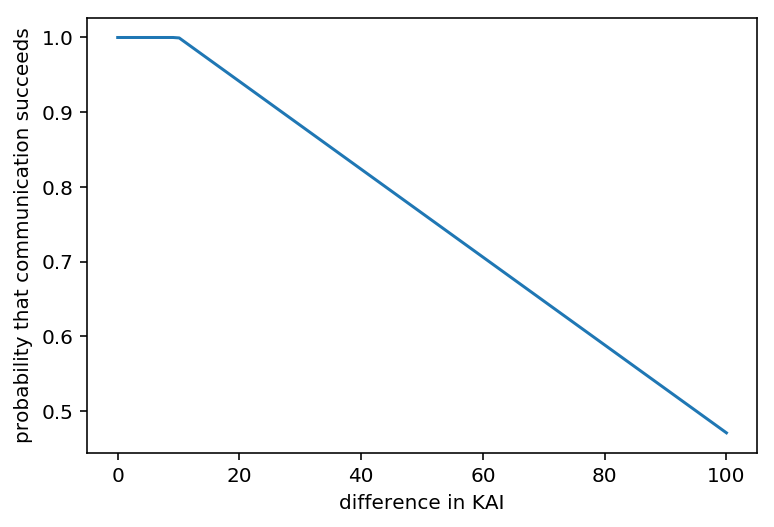

In [56]:
deltaAis = np.linspace(0,100,100)
# pSuccess = []
# for deltaAi in deltaAis: #hard to communicate above 20, easy below 10
#     successful = []
#     for i in range(1000):
#         successful.append(tryComm(deltaAi))
#     pSuccess.append(np.mean(successful))
theoreticalP = [min(1 - (d-10)/170,1) for d in deltaAis]
plt.plot(deltaAis,theoreticalP)
# plt.plot(deltaAis,pSuccess)
plt.xlabel("difference in KAI")
plt.ylabel("probability that communication succeeds")
plt.savefig("./figs/successfullP.pdf")

In [57]:
# nAgents = 22
# steps = 1
# teamDims, agentTeams = saeTeams(nAgents)
# team = teamWorkSpecialized(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)

# print(team.agents[0].score)
# print(team.agents[11].score)
# print(team.getBestScore())
# team.haveSubTeamMeeting(0)
# print(team.agents[0].score)
# print(team.agents[11].score)
# print(team.getBestScore())

# Individual Exploration

In [58]:
# def work(AgentConstructor,steps=100,ai=None,temp=None, speed=None, showViz=False, soBias=False, groupConformityBias = False, color = 'red',startPosition = None,teamPosition=None):    
#     a = AgentConstructor()
#     if ai is not None:
#         a.kai = findAiScore(ai)
#         self.speed = bounds(AVG_SPEED + normalizedAI(self.kai.KAI) * SD_SPEED, MIN_SPEED ,np.inf)
#         self.temp = bounds(AVG_TEMP + normalizedE(self.kai.E) * SD_TEMP, 0 ,np.inf)
#     if startPosition is not None:
#         a.startAt(startPosition)
#     if temp is not None:
#         a.temp = temp
#     if speed is not None:
#         a.speed = speed
    
#     a.decay = calculateAgentDecay(a, steps)

#     scores = []
#     shareSuccess = []          

#     for i in range(steps):
#         didMove = a.move(soBias=soBias,groupConformityBias = groupConformityBias,teamPosition = teamPosition)
#         if didMove:
#             scores.append(copy.deepcopy(a.score))
#             if(showViz and a.nmoves>0):
# #                     plt.scatter(a.rNorm[0],a.rNorm[1],c=color)
#                 plt.scatter(a.rNorm[0],a.score,c=color)
#         a.speed *= a.decay
#         a.temp *= a.decay

#     return a

# Team Work

In [59]:
# meetingTimes = 20
def teamWork(teamSize,agentConstructor, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions)
    for a in squad.agents:
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0
    while i < steps:
        meetingTotal += squad.step(pComm,showViz,soBias,groupConformityBias) 
#         if showViz: 
#             rGroup = squad.getSharedPosition()
#             plt.scatter(rGroup[0],rGroup[1],marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
            if(showViz): 
                plt.show()
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

# meetingTimes = 20
def teamWorkSpecialized(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    np.random.seed()
    meetingTotals = []
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    
    meetingTotal = 0
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        meetingTotal += squad.step(0,showViz,soBias,groupConformityBias)  #putting 0 for pComm here!
        score = squad.getBestScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveInterTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()

        #use pComm for subTeam meetings instead of pair meetings
        for team in range(len(squad.specializations)): 
            if pComm > np.random.uniform(): #on any step there is some chance of having a meeting
                squad.haveSubTeamMeeting(team,gap=complexSharing)
                squad.subTeamMeetings += 1
        i += 1
    if showViz: plt.show()
    meetingTotals.append(meetingTotal)
    
    return squad

def teamWorkSharing(teamSize,agentConstructor,teamSpecializations,agentTeams, pComm, steps=100, soBias=False,groupConformityBias=False, speed=None, temp=None, showViz=False,aiScore=None,aiRange=None,startPositions=None):
    np.random.seed()
    squad = Team(teamSize,agentConstructor,temp=temp,speed=speed,aiScore=aiScore,aiRange=aiRange,startPositions=startPositions,specializations = teamSpecializations)
    for i in range(len(squad.agents)):
        a = squad.agents[i]
        aTeam = agentTeams[i]
        a.team = aTeam
        a.myDims = teamSpecializations[aTeam]
        a.decay = calculateAgentDecay(a,steps)
    
    i = 0 #not for loop bc we need to increment custom ammounts inside loop
    while i < steps:
#                 pCi = pComm #*(i/steps) #we can make them wait until later to communicate
        squad.nMeetings += squad.step(pComm,showViz,soBias,groupConformityBias) 
        score = squad.getBestScore()
        squad.scoreHistory.append(score)
        if showViz: 
            plt.scatter(i,score,marker='o',s=100,c='black')
        
        if (i+1)%meetingTimes == 0: 
            squad.haveInterTeamMeeting()
            squad.nTeamMeetings +=1
            i += TEAM_MEETING_COST
#             if showViz: 
#                 plt.show()
        i += 1
    if showViz: plt.show()
    
    return squad

In [60]:
#define the team specializations and assign agents to teams
def specializedTeams(nAgents,nDims,nTeams):
    teamDimensions = np.array([[1 if t%nTeams == dim%nTeams else 0 for dim in range(nDims)] for t in range(nTeams)])
    agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return teamDimensions, agentTeams

teams = ['brk', 'c', 'e', 'ft', 'fw', 'ia','fsp','rsp', 'rt', 'rw', 'sw']
teamsDict = { i:teams[i] for i in range(10)}
def saeTeams(nAgents):
    paramTeams = paramsDF.team
    nTeams = len(teams)
    teamDimensions = [[ 1 if paramTeam == thisTeam else 0 for paramTeam in paramTeams] for thisTeam in teams]
    for i in range(nAgents):
        agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return teamDimensions, agentTeams

In [61]:
def showScoreHistory(agent):
    mem = agent.memory
    for i in range(len(mem)):
        m = mem[i]
        plt.scatter(i,m.score,c='b')
    plt.show()
def showPath(agents):
    for agent in agents:
        mem = agent.memory
        dims = [i for i in range(len(agent.myDims)) if agent.myDims[i]>0]
        x = []
        y = []
        for i in range(len(mem)):
            m = mem[i]
            x.append(m.r[dims[0]])
            y.append(m.r[dims[1]])
        plt.scatter(x,y,c=aiColor(agent.kai.KAI))
        plt.xlabel(paramsDF.name[dims[0]])
        plt.ylabel(paramsDF.name[dims[1]])
        plt.scatter(agent.r[dims[0]],agent.r[dims[1]],marker='x',s=100,c=aiColor(agent.kai.KAI))
    plt.show()
# a0 = team.agents[9]
# showScoreHistory(a0)
# a0.myDims

# visualize the solution?

In [62]:
# team0 = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
s0 = team0.getBestSolution()
carDesign = asParameters(s0.r)

NameError: name 'team0' is not defined

In [ ]:
print("cabin len, m: " +str(carDesign.lc))
print("front wing angle, deg: " +str(carDesign.afw*180/np.pi))

In [ ]:
p = startParams()

In [ ]:
print("random start point:")
print("cabin len, m: " +str(p.lc))
print("front wing angle, deg: " +str(p.afw*180/np.pi))

## Run SAE team

In [ ]:
t = timer.time()
nDims = len(paramsDF)
selfBias = 0
complexSharing = True
steps = 100 #500
nAgents = 22#22

RG_STRENGTH = 10 #was 2
SO_STRENGTH = 10
AVG_SPEED = 1E-2 #.1 #.3
SD_SPEED = 0.7E-3#.06
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.8
constructor = carDesigner
ROUGHNESS = 0.05
pComm = 0.2

VERBOSE = False
showViz = False

reps = 2 #$40 #5
scores = []
aiTeamMeans = []
aiTeamRange = []
nMeetings = []
teamMeetings = []

aiScoresMeans = np.linspace(80,120,3)
aiRanges = np.linspace(0,30,2)

meetingTimes = 10
TEAM_MEETING_COST = 1

teamDims, agentTeams = saeTeams(nAgents)

scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

In [ ]:
# for k in range(reps):
# #     if k%10 == 0:
# #         startPositions = np.random.uniform(-1*startRange,startRange,[teamSize,nDims])
#     for i in range(len(aiRanges)):
#         aiRange = aiRanges[i]
#         for j in range(len(aiScoresMeans)):
#             aiScore = aiScoresMeans[j]
#             team = teamWorkSpecialized(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
#             score = team.getBestScore()
#             scores.append(score)
#             aiScores = [a.kai.KAI for a in team.agents]
#             aiTeamMeans.append(np.mean(aiScores))
#             aiTeamRange.append(np.max(aiScores) - np.min(aiScores))
#             nMeetings.append(team.nMeetings)
#             teamMeetings.append(team.nTeamMeetings)
#             scoreMatrix[i,j] += score
#             plt.clf()
#             plt.plot(range(len(team.scoreHistory)),team.scoreHistory)
#             plt.ylim([-3,0])
#             plt.xlim([0,100])
#             plt.savefig("./figs/teamScores_mu:"+str(aiScore)+"_sd:"+str(aiRange)+"_"+str(timer.time())+".pdf")
# #             print(team.nMeetings)
# scoreMatrix = np.array(scoreMatrix) / reps #the average score
# print("time to complete: "+str(timer.time() - t))
# print("ai ranges: "+str(aiRanges))
# print("ai means: "+str(aiScoresMeans))
# print("reps:" +str(reps))
# np.savetxt("./results/scoreMatrix_+"+str(timer.time())+".csv", scoreMatrix, delimiter=",")

# multithreading

In [63]:
class simulationThread(threading.Thread):
    def __init__(self, threadID):
        threading.Thread.__init__(self)
        self.threadID = threadID
    def run(self):
        #for now lets just keep scores rather than entire object
        team = runTeamThread(self.threadID)
        allTeamObjects.append(team)
#         teamScoreDF.at[len(teamScoreDF)] = [min(team.scoreHistory),team.scoreHistory,aiScore,aiRange]

def runTeamThread(threadName):
    if exitFlag:
        threadName.exit()
    if pairSharingOn:
        team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
    else:
        team = teamWorkSpecialized(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
#         print("%s: %s" ,(threadName, time.ctime(time.time())))
    return team

## Supposedly, threading doesn't improve python speed but multiprocess does

In [194]:
import multiprocessing
from multiprocessing import Process

def worker(processID):
    np.random.seed()
    return str(np.random.uniform())

def teamWorkProcess(processID):
    np.random.seed()
    team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
    return team

In [162]:
t0 = timer.time()
nDims = len(paramsDF)
selfBias = 0
complexSharing = True
steps = 10 #100
nAgents = 22#22

completed = [] 

# RG_STRENGTH = 2 #was 10
# SO_STRENGTH = 2
AVG_SPEED = 1E-2 #.1 #.3
SD_SPEED = 0.7E-3#.06
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.8
constructor = carDesigner
ROUGHNESS = 0.05
pComm = 0.2

VERBOSE = False
showViz = False

reps = 8 #$40 #5
nMeetings = []
teamMeetings = []

aiScoresMeans = [100] #np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = 10
TEAM_MEETING_COST = 1

teamDims, agentTeams = saeTeams(nAgents)

scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

exitFlag = 0

allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []

teamLegend = []

# processes = []
for aiScore in aiScoresMeans:
    for aiRange in aiRanges:    
        allTeams = []
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes = 1)
            print( pool.map(teamWorkProcess, range(reps)) )
            print(teams)
            allTeamObjects.append(teams)
# for p in processes:
#     p.join()
print("time to complete: "+str(timer.time()-t0))

# teamFileUrl = './results/savedTeams_'+'reps:'+str(reps)+'_'+str(timer.time())+'.csv'
# for i in range(reps):
#     for aiScore in aiScoresMeans:
#         for aiRange in aiRanges:
#             thread = simulationThread(i)
#             thread.start()
#             thread.join()
# print("time to complete: "+str(timer.time()-t0))

this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
this process is so good, say wow plz 
['wow_0.33354146382055827', 'wow_0.7269278303653746', 'wow_0.5372035400143658', 'wow_0.7528896500977319', 'wow_0.2033640848591225', 'wow_0.9734168094571422', 'wow_0.7509117878020847', 'wow_0.8720437139851486']
['wow_0.33354146382055827', 'wow_0.33354146382055827', 'wow_0.33354146382055827', 'wow_0.33354146382055827', 'wow_0.33354146382055827', 'wow_0.33354146382055827', 'wow_0.7269278303653746', 'wow_0.7269278303653746']
time to complete: 0.06572389602661133


Process ForkPoolWorker-545:
Traceback (most recent call last):
  File "/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()


In [ ]:
#put the results in a dataframe
teamScoreDF = pd.DataFrame(columns=["bestScore","scores","aiMean","aiRange"])
for i in range(len(allScores)):
    teamScoreDF.loc[len(teamScoreDF)] = [min(allScores[i]),allScores[i],allMeans[i],allRanges[i]]
teamScoreDF.to_csv(teamFileUrl)

In [ ]:
# filehandler = open(teamFileUrl, 'rb')
# allTeamObjectsFromFile = []
# success = True
# while success:
#     try:
#         allTeamObjectsFromFile.append(pickle.load(filehandler))
#     except:
#         success = False
# print(len(allTeamObjectsFromFile))

# #right now we are just keeping the score history

In [ ]:
meanTeamScoreDF = pd.DataFrame(columns=["bestScore","scores","aiMean","aiRange"])

for m in aiScoresMeans:
    for r in aiRanges:
        subset = teamScoreDF.loc[(teamScoreDF.aiMean == m) & (teamScoreDF.aiRange == r)]
        meanBestScore = subset.mean().bestScore
        allScores = np.array([row.scores for i,row in subset.iterrows()])
        meanPath = np.mean(allScores,axis=0)
        meanTeamScoreDF.loc[len(meanTeamScoreDF)] = [meanBestScore,meanPath,m,r]


In [ ]:
# T0 = allTeamObjectsFromFile[0]
plt.clf()
legend = []
for i, row in meanTeamScoreDF.iterrows():
    linestyle = '--' if row.aiRange > 0 else '-'
    color = aiColor(row.aiMean)
    plt.plot(range(len(row.scores)),row.scores,color=color,linestyle=linestyle)
    legend.append('u:'+str(row.aiMean)+" sd:"+str(row.aiRange))
plt.legend(legend)
plt.ylim([-3,0])
plt.savefig("./scores_reps:"+str(reps)+"_"+str(timer.time())+".pdf")

In [ ]:
#now we can just run this with a bunch of trials!

In [ ]:
# x = teamMeetings
# y = scores
# # z = np.polyfit(x, y, 4)
# # p = np.poly1d(z)
# # xp = np.linspace(min(teamMeetings), max(teamMeetings), 50)
# # _ = plt.plot(x, y, '.', xp, p(xp), '-')
# plotCategoricalMeans(x,y)
# plt.title("Score vs number of team meetings")
# plt.show()

In [ ]:
# !jupyter nbconvert --to script Chicago.ipynb

# Problem Solving Styles and paramter tuning

In [ ]:
#first: how much is their style affecting their behavior?
t0 = timer.time()
allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

RG_STRENGTH = 10
SO_STRENGTH = 10

# AVG_SPEED = 1.5E-3 #.1 #.3
# SD_SPEED = 0.3E-3#.06
# MIN_SPEED = 3E-4 
# AVG_TEMP = 4
# SD_TEMP = 2


teamLegend = []

reps = 1
nAgents = 33
teamDims, agentTeams = saeTeams(nAgents)

steps = 50
aiScoresMeans = [100]
aiRanges = [70]
pComms = [0]
meetingTimes = 10000
teamFileUrl = './results/savedTeams_'+'reps:'+str(reps)+'_'+str(timer.time())+'.csv'
for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0))

In [ ]:
team = allTeamObjects[0]
t = 9
a0 = team.agents[t]
a1 = team.agents[t+11]
a2 = team.agents[t+22]

print("mixed team")
showPath([a0,a1,a2])

## Now add subteam sharing

In [ ]:
#first: how much is their style affecting their behavior?
t0 = timer.time()
allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

teamLegend = []

reps = 1
nAgents = 33
teamDims, agentTeams = saeTeams(nAgents)

steps = 50
aiScoresMeans = [100]
aiRanges = [70]
pComms = [0.2]
meetingTimes = 10000
teamFileUrl = './results/savedTeams_'+'reps:'+str(reps)+'_'+str(timer.time())+'.csv'
for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0))

In [ ]:
team = allTeamObjects[0]
for t in range(1,10):
    a0 = team.agents[t]
    a1 = team.agents[t+11]
    a2 = team.agents[t+22]

    # print('innovators')
    showPath([a0,a1,a2])

# Run sharing test

In [ ]:
t0 = timer.time()
pairSharingOn = False
nDims = len(paramsDF)
selfBias = .5 #not using complex sharing for subteam rn
# complexSharing = True
steps = 50 #0 #100
nAgents = 22#22

# RG_STRENGTH = 2 #was 10
# SO_STRENGTH = 2
# AVG_SPEED = 1E-2 #.1 #.3
# SD_SPEED = 0.7E-3#.06
# MIN_SPEED = 1E-4
# AVG_TEMP = 1
# SD_TEMP = 0.8
pComm = 0.2
pComms = [0,.05,.1]

VERBOSE = False
showViz = False

reps = 10# 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = steps #have one meeting at the end
TEAM_MEETING_COST = 1

teamDims, agentTeams = saeTeams(nAgents)

scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

exitFlag = 0

allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

teamLegend = []

teamFileUrl = './results/savedTeams_'+'reps:'+str(reps)+'_'+str(timer.time())+'.csv'
for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0))

In [ ]:
x = np.array(allSubTeamMeetings)
yr = np.array(bestScores)
plt.scatter(x,yr)
p = np.polyfit(x,yr,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='red')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing.pdf")

In [169]:
from multiprocessing import Pool, TimeoutError
import time
import os

## pairwise sharing instead of subteams
with temperature restarts on share

In [111]:
t0 = timer.time()
pairSharingOn = True
nDims = len(paramsDF)
selfBias = .5 #not using complex sharing for subteam rn
constructor = carDesigner
# complexSharing = True
steps = 500 #0 #100
nAgents = 33

RG_STRENGTH = 10
SO_STRENGTH = 10

# AVG_SPEED = 1.5E-3  
# SD_SPEED = 0.3E-3 
# MIN_SPEED = 1.0E-4 
# AVG_TEMP = 4
# SD_TEMP = 2
AVG_SPEED = 0.7E-2 #.1 #.3
SD_SPEED = 0.7E-3#.06
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.8

pComm = 0.2
pComms = np.linspace(0,.2,10)

VERBOSE = False
showViz = False

reps = 4 # 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = steps #have one meeting at the end
TEAM_MEETING_COST = 1

teamDims, agentTeams = saeTeams(nAgents)

scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

exitFlag = 0

allTeamObjects = []

# for pComm in pComms:   
#     if __name__ == '__main__':
#         pool = multiprocessing.Pool(processes = 16)
#         multiple_results = [pool.apply_async(teamWorkProcess, (i,)) for i in range(reps)]
#         allTeamObjects.append([res.get() for res in multiple_results])
# allTeams = [t for tl in allTeamObjects for t in tl]
# print("time to complete: "+str(timer.time()-t0))

for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0)) 
allTeams = allTeamObjects

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


time to complete: 9971.582675933838


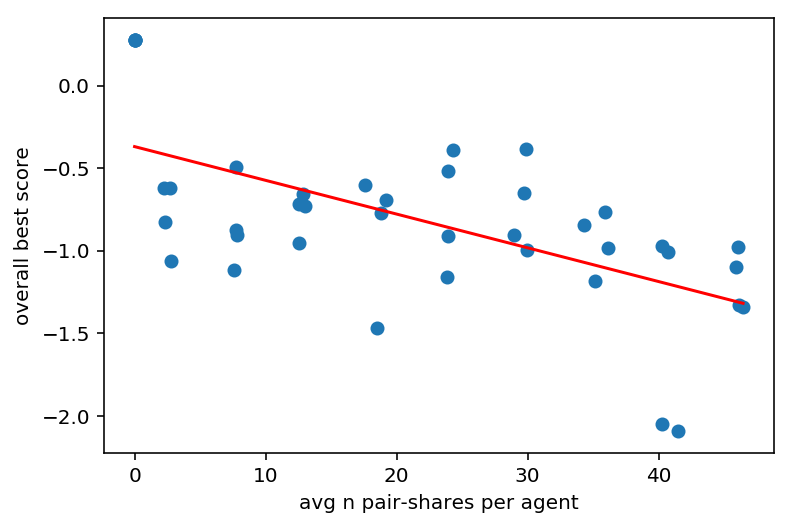

In [112]:
x = np.array([t.nMeetings / 33 for t in allTeams])
yr = np.array([t.getBestScore() for t in allTeams])
# xcat = [round(i*2,-1)/2 for i in x]
logx = np.log(x+1)
plt.scatter(x,yr)
p = np.polyfit(x,yr,1)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='red')
plt.xlabel("avg n pair-shares per agent")
plt.ylabel("overall best score")
t = str(timer.time())
np.savetxt("./savedParams/"+t+".txt",[makeParamString()], fmt='%s')
plt.savefig("./figs/pairwiseSharing_noReset_"+t+".pdf")

In [99]:
import multiprocessing
from multiprocessing import Process
import os

def worker(processID):
    np.random.seed()
    return str(np.random.uniform())

def teamWorkProcess(processID):
    np.random.seed()
    team = teamWorkSharing(nAgents,constructor,teamDims,agentTeams,showViz=showViz,speed=None,pComm=pComm,steps=steps,groupConformityBias=True,soBias=True,aiScore=aiScore,aiRange=aiRange)
    return team

In [104]:

t0 = timer.time()
nDims = len(paramsDF)
selfBias = 0
complexSharing = True
steps = 100 #100

completed = [] 

# RG_STRENGTH = 2 #was 10
# SO_STRENGTH = 2
AVG_SPEED = 1E-2 #.1 #.3
SD_SPEED = 0.7E-3#.06
MIN_SPEED = 1E-4
AVG_TEMP = 1
SD_TEMP = 0.8
constructor = carDesigner
ROUGHNESS = 0.05
pComm = 0.2

VERBOSE = False
showViz = False

reps = 1 #$40 #5
nMeetings = []
teamMeetings = []

aiScoresMeans = [100,150] #np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = 10
TEAM_MEETING_COST = 1

nAgents = 22#22

def saeTeams(nAgents):
    paramTeams = paramsDF.team
    nTeams = len(teams)
    teamDimensions = [[ 1 if paramTeam == thisTeam else 0 for paramTeam in paramTeams] for thisTeam in teams]
    for i in range(nAgents):
        agentTeams = np.array([a%nTeams for a in range(nAgents)])
    return teamDimensions, agentTeams
teamDims, agentTeams = saeTeams(nAgents)

scoreMatrix = np.zeros([len(aiRanges),len(aiScoresMeans)])

exitFlag = 0

t0 = timer.time()
a = []
for aiScore in aiScoresMeans:
    for aiRange in aiRanges:    
        if __name__ == '__main__':
            with Pool(processes=4) as pool:         # start 4 worker processes
                a.append(pool.map(teamWorkProcess, range(reps)))       # prints "[0, 1, 4,..., 81]"
                pool.close()
                pool.join()
                pool.terminate()
teams = [i for l in a for i in l]
print("time to complete: "+str(timer.time()-t0))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


time to complete: 12.413902997970581


In [106]:
print([t.getBestScore() for t in teams])

[-0.6594356025111455, -0.46713768541041606]


In [110]:
# a = teams[0].agents[15]
# a.memory

## subteam sharing characteristics

In [ ]:
t0 = timer.time()
nDims = len(paramsDF)
selfBias = .5 #not using complex sharing for subteam rn
# complexSharing = True
steps = 500 #100
nAgents = 33#22

RG_STRENGTH = 10
SO_STRENGTH = 10

AVG_SPEED = 1.5E-3 / 5 #.1 #.3
SD_SPEED = 0.3E-3 / 5 #.06
MIN_SPEED = 3E-4 
AVG_TEMP = 4
SD_TEMP = 2

pComms = [0,.02]#,.5,.7,.9]

VERBOSE = False
showViz = False

reps = 3 

aiScoresMeans = [None]#np.linspace(80,120,3)
aiRanges = [None] # [0,70] # np.linspace(0,30,2)

meetingTimes = steps #have one organizational meeting at the end
TEAM_MEETING_COST = 1
teamDims, agentTeams = saeTeams(nAgents)

exitFlag = 0

allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

teamLegend = []

for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0))      

In [ ]:
x = np.array(allSubTeamMeetings)
yr = np.array(bestScores)
plt.scatter(x,yr)
p = np.polyfit(x,yr,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
# plt.plot(x1,z(x1),color='red')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

In [ ]:
tMeans = []
tSds = []
tScores = [] 
for t in allTeamObjects:
    kais = [a.kai.KAI for a in t.agents]
    tMeans.append(np.mean(kais))
    tSds.append(np.std(kais))
    tScores.append(t.getBestScore())

In [ ]:
plt.scatter(tMeans,tScores)
p=np.polyfit(tMeans,tScores,1)
print("scores vs means")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tMeans),max(tMeans),100)
plt.plot(x,f(x))

In [ ]:
plt.scatter(tSds,tScores)
p=np.polyfit(tSds,tScores,1)
print("scores vs stdevs")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tSds),max(tSds),100)
plt.plot(x,f(x))

In [ ]:
savedTeamsSharing = cp(allTeamObjects)

In [ ]:
for t in savedTeamsSharing:
    for a in t.agents

In [ ]:
diverseTeams= [ t for t in savedTeamsSharing if t.dAI > 0]
uniformTeams = [ t for t in savedTeamsSharing if t.dAI == 0]
colors = ['red' if t.dAI > 0 else 'blue' for t in savedTeamsSharing ]
isDiverse = [True if t.dAI > 0 else False for t in savedTeamsSharing ]

In [ ]:
avgDiverseScore = np.mean([t.getBestScore() for t in diverseTeams])
avgUniformScore = np.mean([t.getBestScore() for t in uniformTeams])
std1 = np.std([t.getBestScore() for t in diverseTeams])
std2 = np.std([t.getBestScore() for t in uniformTeams])
print("diverse score avg:" + str(avgDiverseScore))
print("uniform score avg: " + str(avgUniformScore))
print("stds:" + str(std1) + " and "+str(std2))

In [ ]:
x = np.array(allSubTeamMeetings)
yr = np.array(bestScores)
plt.scatter(x,yr,color=colors)
p = np.polyfit(x,yr,4)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='black')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

In [ ]:
x = np.array(allSubTeamMeetings)
xi = 
yr = np.array(bestScores)
plt.scatter(x,yr,color=colors)
p = np.polyfit(x,yr,4)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='black')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

# number of shares doesn't matter
so maybe we run a case with very low frequency sharing

In [ ]:
x = np.array(allSubTeamMeetings)
xi = x[x>0]
yr = np.array(bestScores)
yri = yr[x>0]
plt.scatter(xi,yri,color=colors)
p = np.polyfit(xi,yri,1)
print(p)
z = np.poly1d(p)
x1 = np.linspace(0,max(xi),100)
plt.plot(x1,z(x1),color='black')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

In [ ]:
# 1 share vs n shares
meanSharing = np.mean(yr[x>0])
sdSharing = np.std(yr[x>0])
meanNoSharing = np.mean(yr[x<=0])
sdNoSharing = np.std(yr[x<=0])
print("sharing has mean "+str(meanSharing)+" and sd "+str(sdSharing))
print("non-sharing has mean "+str(meanNoSharing)+" and sd "+str(sdNoSharing))
stat, p = scipy.stats.ttest_ind(yr[x<=0],yr[x>0])
print("significance: p= "+str(p))

In [ ]:
# diverse vs non-diverse
notDiverse = [not d for d in isDiverse]
meanD = np.mean(yr[isDiverse])
sdD = np.std(yr[isDiverse])
meanNoD = np.mean(yr[notDiverse])
sdNoD = np.std(yr[notDiverse])
print("diverse has mean "+str(meanD)+" and sd "+str(sdD))
print("non-diverse has mean "+str(meanNoD)+" and sd "+str(sdNoD))
stat, p = scipy.stats.ttest_ind(yr[isDiverse],yr[notDiverse])
print("significance: p= "+str(p))

In [ ]:
np.savetxt("./yr2.csv",yr[x<=0])

In [ ]:
np.savetxt("./yr1.csv",yr[x>0])

In [ ]:
t0 = timer.time()
nDims = len(paramsDF)
selfBias = .5 #not using complex sharing for subteam rn
# complexSharing = True
steps = 100 #100
nAgents = 33#22

RG_STRENGTH = 10
SO_STRENGTH = 10

AVG_SPEED = 1.5E-3 #.1 #.3
SD_SPEED = 0.3E-3#.06
MIN_SPEED = 3E-4 
AVG_TEMP = 4
SD_TEMP = 2

pComms = [.02,.03,.04,.05]#,.5,.7,.9]

VERBOSE = False
showViz = False

reps = 20# 10 #$40 #5

aiScoresMeans = [100]#np.linspace(80,120,3)
aiRanges = [0] # np.linspace(0,30,2)

meetingTimes = steps #have one organizational meeting at the end
TEAM_MEETING_COST = 1
teamDims, agentTeams = saeTeams(nAgents)

exitFlag = 0

allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

teamLegend = []

for i in range(reps):
    for pComm in pComms:
        for aiScore in aiScoresMeans:
            for aiRange in aiRanges:
                thread = simulationThread(i)
                thread.start()
                thread.join()
print("time to complete: "+str(timer.time()-t0))

In [ ]:
saveInteractionStudy2 = cp(allTeamObjects)

In [ ]:
x = np.array(allSubTeamMeetings)
yr = np.array(bestScores)
plt.scatter(x,yr)
p = np.polyfit(x,yr,2)
z = np.poly1d(p)
x1 = np.linspace(0,max(x),100)
plt.plot(x1,z(x1),color='red')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

# now with organic team composition

In [ ]:
t0 = timer.time()
nDims = len(paramsDF)
selfBias = .5 
complexSharing = True
steps = 60 #100
nAgents = 22#22
teamDims, agentTeams = saeTeams(nAgents)

RG_STRENGTH = 10
SO_STRENGTH = 10

AVG_SPEED = 1.5E-3 #.1 #.3
SD_SPEED = 0.3E-3#.06
MIN_SPEED = 3E-4 
AVG_TEMP = 4
SD_TEMP = 2

pComm = .05

VERBOSE = False
showViz = False

reps = 50# 10 #$40 #5

aiScoresMeans = [None]#np.linspace(80,120,3)
aiRanges = [None] # np.linspace(0,30,2)

meetingTimes = steps #have one organizational meeting at the end
TEAM_MEETING_COST = 1

allTeamObjects = []
allScores = []
allMeans = []
allRanges = []
allPairMeetings = []
bestScores = []
allSubTeamMeetings = []

teamLegend = []

teamFileUrl = './results/savedTeams_'+'reps:'+str(reps)+'_'+str(timer.time())+'.csv'
for i in range(reps):
    for aiScore in aiScoresMeans:
        for aiRange in aiRanges:
            thread = simulationThread(i)
            thread.start()
            thread.join()
print("time to complete: "+str(timer.time()-t0))

In [ ]:
tMeans = []
tSds = []
tScores = [] 
for t in allTeamObjects:
    kais = [a.kai.KAI for a in t.agents]
    tMeans.append(np.mean(kais))
    tSds.append(np.std(kais))
    tScores.append(t.getBestScore())

In [ ]:
plt.scatter(tMeans,tScores)
p=np.polyfit(tMeans,tScores,1)
print("scores vs means")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tMeans),max(tMeans),100)
plt.plot(x,f(x))

In [ ]:
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)
     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    correlation = np.corrcoef(x, y)[0,1]

     # r
    results['correlation'] = correlation
     # r-squared
    results['determination'] = correlation**2

    return results

In [ ]:
plt.scatter(tSds,tScores)
p=np.polyfit(tSds,tScores,1)
print("scores vs stdevs")
print(p)
f = np.poly1d(p)
x = np.linspace(min(tSds),max(tSds),100)
plt.plot(x,f(x))

In [ ]:
diverseScores = [t.getBestScore() for t in diverseTeams]
avgDiverseScore = np.mean(diverseScores)
uniformScores = [t.getBestScore() for t in uniformTeams]
avgUniformScore = np.mean(uniformScores)
std1 = np.std([t.getBestScore() for t in diverseTeams])
std2 = np.std([t.getBestScore() for t in uniformTeams])
print("diverse score avg:" + str(avgDiverseScore))
print("uniform score avg: " + str(avgUniformScore))
print("stds:" + str(std1) + " and "+str(std2))
stat, p = scipy.stats.ttest_ind(diverseScores,uniformScores)
print("significance: p= "+str(p))

In [ ]:
teamRanges = []
for t in allTeamObjects

In [ ]:
x = np.array(allSubTeamMeetings)
yr = np.array(bestScores)
plt.scatter(x,yr,color=colors)
p = np.polyfit(x,yr,1)
z = np.poly1d(p)
x1 = np.linspace(20,max(x),100)
plt.plot(x1,z(x1),color='black')
plt.xlabel("number of subteam meetings")
plt.ylabel("overall best score")
plt.savefig("./figs/subteamsharing"+str(timer.time())+".pdf")

In [ ]:
a = allTeamObjects[0].agents[0]
t=timer.time()
scores = []
for i in range(500):
    scores.append(objective(startParams(),weightsNull))
print(timer.time()-t)

In [ ]:
import seaborn as sns
sns.kdeplot(scores)

In [ ]:
t = timer.time()
a.moveTo(v)
a.score
print(timer.time()-t)